Business Understanding- how does the cycling trip data help us to improve the experience for users of the scheme? 

Customers have issues with availability of bikes or spaces and problems with planning for routes, so what aspects of the data can we use to solve these issues?

Initialise libraries and import data

In [1]:

import matplotlib
import pandas as pd
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import math


%matplotlib inline
    
# Downloading the csv file from  GitHub account


url1 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2001.csv"
download1 = requests.get(url1).content

df1 = pd.read_csv(io.StringIO(download1.decode('utf-8')))

url2 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2002.csv"
download2 = requests.get(url2).content

df2 = pd.read_csv(io.StringIO(download2.decode('utf-8')))

url3 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2003.csv"
download3 = requests.get(url3).content

df3 = pd.read_csv(io.StringIO(download3.decode('utf-8')))

url4 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2004.csv"
download4 = requests.get(url4).content

df4 = pd.read_csv(io.StringIO(download4.decode('utf-8')))

url5 = "https://raw.githubusercontent.com/docju/CyclingData/main/2019%20-%2005.csv"
download5 = requests.get(url5).content

df5 = pd.read_csv(io.StringIO(download5.decode('utf-8')))

df=pd.concat([df1,df2,df3,df4,df5])


df.head()

,month,trip_duration_sec,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender
0,January,80825,229.0,Foothill Blvd at 42nd Ave,196.0,Grand Ave at Perkins St,4861,Subscriber,1989.0,Male
1,January,65900,4.0,Cyril Magnin St at Ellis St,134.0,Valencia St at 24th St,5506,Subscriber,1989.0,Male
2,January,62633,245.0,Downtown Berkeley BART,157.0,65th St at Hollis St,2717,Customer,1965.0,Female
3,January,44680,85.0,Church St at Duboce Ave,53.0,Grove St at Divisadero,4557,Customer,1974.0,Male
4,January,60709,16.0,Steuart St at Market St,28.0,The Embarcadero at Bryant St,2100,Customer,NaN,NaN


Data Understanding (also helping to answer question 1): Find the types of variable and describe the Numeric ones

In [2]:
print(df.shape)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

##1053067 rows, 10 columns

##create list of categorial variables
cat_df = df.select_dtypes(include=['object']).copy()
cat_columns=list(cat_df.columns.values)

print(len(cat_columns)) ## 5 categorical columns
##create list of numeric variables
num_df= df.select_dtypes(include=['float','integer']).copy()
num_columns=list(num_df.columns.values)
print(len(num_columns)) ## 5 numerical columns, of which 3 could be considered ID variables

df.describe()

(1053067, 10)
5
5


,trip_duration_sec,start_station_id,end_station_id,bike_id,member_birth_year
count,1053067.00000,1052322.00000,1052322.00000,1053067.00000,1003691.00000
mean,779.36304,139.43299,137.81954,3883.04180,1984.67115
std,1891.00616,114.36218,114.27888,1974.97215,10.10330
min,61.00000,3.00000,3.00000,11.00000,1878.00000
25%,340.00000,44.00000,44.00000,2165.00000,1980.00000
50%,542.00000,102.00000,100.00000,4549.00000,1987.00000
75%,848.00000,239.00000,235.00000,5428.00000,1992.00000
max,86114.00000,427.00000,427.00000,7196.00000,2001.00000


Find the proportion of missing values for each variable

In [3]:
df.isna().mean()


month                0.00000
trip_duration_sec    0.00000
start_station_id     0.00071
start_station_name   0.00071
end_station_id       0.00071
end_station_name     0.00071
bike_id              0.00000
user_type            0.00000
member_birth_year    0.04689
member_gender        0.04688
dtype: float64

This looks like there are not many rows with missing values. We can reasonably drop rows with missing values and not compromise on lost data

In [4]:
no_na=df.dropna().copy()

print(len(no_na)) ##1002956 rows remain

print(len(no_na)/len(df)) ##95% of original data remains

##

1002956
0.9524142338521671


What is the distribution of trip duration and birth year?

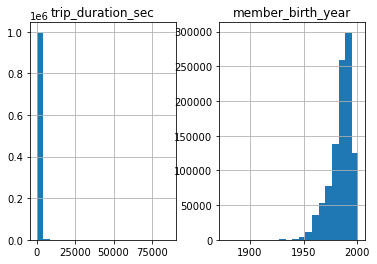

In [5]:
no_na[['trip_duration_sec', 'member_birth_year']].hist(bins=20);
## Results show outliers in trip duration in seconds and maybe some bad data in birth year where there are people born before 1900

In [6]:
 no_na[['trip_duration_sec']].sort_values(['trip_duration_sec'], 
                                             ascending=[False])
## The top values for trip duration correspond to a 24 hour period. Similarly, the lowest values are 61 seconds, which suggests either a very short trip or some kind of error

,trip_duration_sec
12667,86114
70083,85496
30881,84967
230332,84908
223092,84792
...,...
111400,61
63401,61
52902,61
29006,61


Investigate these unusual looking values for trip duration- first the large ones

In [7]:
## Get the length of trip in hours and minutes
no_na['trip_duration_hr'] = round(no_na['trip_duration_sec']/3600)
no_na['trip_duration_min'] = round(no_na['trip_duration_sec']/60)

##We can see that 99% of trips are shorter than 1.5 hours and potentially we could count data larger than 6 hours as a whole- either long trips or errors. We could even check at another time if these correspond to particular stations or bike IDs
no_na['trip_duration_hr'].value_counts(ascending=False)/len(no_na)



0.00000    0.95932
1.00000    0.03536
2.00000    0.00272
3.00000    0.00093
4.00000    0.00039
5.00000    0.00021
6.00000    0.00017
7.00000    0.00011
9.00000    0.00009
8.00000    0.00007
11.00000   0.00006
13.00000   0.00005
14.00000   0.00005
15.00000   0.00005
17.00000   0.00005
10.00000   0.00005
12.00000   0.00005
18.00000   0.00004
16.00000   0.00004
20.00000   0.00004
19.00000   0.00004
21.00000   0.00003
22.00000   0.00003
23.00000   0.00002
24.00000   0.00001
Name: trip_duration_hr, dtype: float64

Now the very small ones

In [8]:
## Find instances where the trip is less than 70 seconds

##We can see that 99% of trips are shorter than 1.5 hours and potentially we could count data larger than 6 hours as a whole- either long trips or bundles. We could even check if these correspond to particular stations or bike IDs
no_na[no_na['trip_duration_sec']<70]['start_station_name'].value_counts(ascending=False)
## There is no particular value for small trips that dominates, which suggests there is not a default value and that the data can be assumed to be reliable


Bancroft Way at College Ave                                  96
San Fernando St at 4th St                                    31
San Fernando St at 7th St                                    31
San Francisco Caltrain Station 2  (Townsend St at 4th St)    23
San Francisco City Hall (Polk St at Grove St)                22
                                                             ..
Julian St at 6th St                                           1
20th St at Dolores St                                         1
24th St at Chattanooga St                                     1
Cahill Park                                                   1
Scott St at Golden Gate Ave                                   1
Name: start_station_name, Length: 240, dtype: int64

Do the same for the birth year errors

In [9]:
 no_na[['member_birth_year']].sort_values(['member_birth_year'], 
                                             ascending=[False])
## The top values for year are 2001, which makes sense if the scheme is open to those over the age of 18. However the lowest is 1878, which is unlikely.

,member_birth_year
54906,2001.00000
190806,2001.00000
133017,2001.00000
22481,2001.00000
63137,2001.00000
...,...
133646,1878.00000
197150,1878.00000
195932,1878.00000
113766,1878.00000


In [10]:
no_na['member_birth_year'].value_counts(ascending=False)*100/len(no_na)
## a small number of customers have suspiciously low birth years. Let's investigate further

1988.00000   5.72109
1989.00000   5.35437
1990.00000   5.09304
1993.00000   5.03312
1991.00000   4.95136
               ...  
1936.00000   0.00020
1930.00000   0.00020
1910.00000   0.00010
1940.00000   0.00010
1886.00000   0.00010
Name: member_birth_year, Length: 84, dtype: float64

Look at low values for birth year 

In [11]:
no_na[no_na['member_birth_year']<1950]['member_birth_year'].value_counts(ascending=False)*100/len(no_na)

## Again there is no obvious pattern for low values, and no default value. Some customers may have deliberately input a wrong birth year for data protection purposes, others may have mis-typed
## There may also be an issue that a customer inputs "00" and the website interprets that as  "1900", however there is no compelling evidence of this. We can continue to use the other data, but any age-related data will be caveated

1949.00000   0.06860
1945.00000   0.06102
1947.00000   0.05843
1931.00000   0.04537
1948.00000   0.02911
1900.00000   0.02533
1943.00000   0.01825
1942.00000   0.01565
1933.00000   0.00857
1941.00000   0.00828
1946.00000   0.00738
1902.00000   0.00618
1896.00000   0.00528
1920.00000   0.00469
1901.00000   0.00449
1939.00000   0.00409
1944.00000   0.00329
1935.00000   0.00309
1927.00000   0.00199
1938.00000   0.00160
1932.00000   0.00130
1904.00000   0.00100
1878.00000   0.00070
1923.00000   0.00060
1934.00000   0.00040
1930.00000   0.00020
1936.00000   0.00020
1928.00000   0.00020
1911.00000   0.00020
1910.00000   0.00010
1886.00000   0.00010
1940.00000   0.00010
Name: member_birth_year, dtype: float64

<AxesSubplot:ylabel='Frequency'>

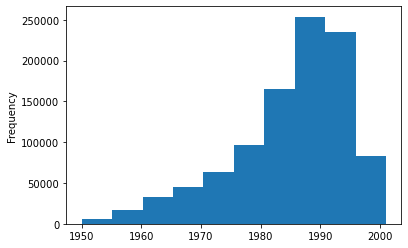

In [12]:
## volumes below 1950 are low so we can remove them- plot histogram for age distribution alone for blog post 
no_na['member_birth_year'][no_na['member_birth_year']>=1950].plot.hist(bins=10)


Categorical variables

In [13]:
print(cat_columns)

['month', 'start_station_name', 'end_station_name', 'user_type', 'member_gender']


In [14]:
##Find distributions for categorical variables 
for col in cat_columns:
    print( no_na[col].value_counts(ascending=False)*100/len(no_na))
    
## Month data shows that "February" is mis-spelled, but otherwsise the data intuitively makes sense, with fewer journeys in winter months and in May

##Start and end data have locations near public transport hubs as their biggest values

##89% of journeys are undertaken by subscribers and 11% by customers

## The gender split shows about 3 times more men than women make use of the scheme

March       24.36348
April       22.71765
January     18.15852
Februrary   17.44364
May         17.31671
Name: month, dtype: float64
San Francisco Caltrain Station 2  (Townsend St at 4th St)   2.01584
Market St at 10th St                                        1.95313
Berry St at 4th St                                          1.61842
San Francisco Ferry Building (Harry Bridges Plaza)          1.60575
Montgomery St BART Station (Market St at 2nd St)            1.53087
                                                              ...  
23rd St at Taylor St                                        0.00060
16th St Depot                                               0.00050
Auzerais Ave at Lincoln Ave                                 0.00030
21st St at Santa Clara St                                   0.00020
SF Test Station                                             0.00010
Name: start_station_name, Length: 370, dtype: float64
San Francisco Caltrain Station 2  (Townsend St at 4th St)   2.927

Preliminary exploration: What are the most common routes taken?

In [15]:
no_na['route']=no_na['start_station_name']+' TO '+no_na['end_station_name']
##Top 5 routes by percentage of trips
print(no_na['route'].value_counts(ascending=False)[:5])
print(no_na['route'].value_counts(ascending=False)[:5]*100/len(no_na))

##Top 5 routes where the time was less than 2 minutes
print(no_na[no_na['trip_duration_sec']<=120]['route'].value_counts(ascending=False)[:5])

## The resulting trips are indeed very close to each other after examining on google maps, so there is no issue here- a likely cause of this is customers trying the scheme out for the first time

San Francisco Ferry Building (Harry Bridges Plaza) TO The Embarcadero at Sansome St    2088
Berry St at 4th St TO San Francisco Ferry Building (Harry Bridges Plaza)               1776
Grand Ave at Perkins St TO 19th Street BART Station                                    1776
The Embarcadero at Sansome St TO Steuart St at Market St                               1689
19th Street BART Station TO Grand Ave at Perkins St                                    1490
Name: route, dtype: int64
San Francisco Ferry Building (Harry Bridges Plaza) TO The Embarcadero at Sansome St   0.20818
Berry St at 4th St TO San Francisco Ferry Building (Harry Bridges Plaza)              0.17708
Grand Ave at Perkins St TO 19th Street BART Station                                   0.17708
The Embarcadero at Sansome St TO Steuart St at Market St                              0.16840
19th Street BART Station TO Grand Ave at Perkins St                                   0.14856
Name: route, dtype: float64
Bancroft Way at 

What are the most common routes by month? Is there any particular trend?

In [16]:
##Data is shown as a percentage of monthly data
print('January routes')
print(no_na[no_na['month']=='January']['route'].value_counts(ascending=False)[:5]*100/len(no_na[no_na['month']=='January']))
print('February routes')
print(no_na[no_na['month']=='Februrary']['route'].value_counts(ascending=False)[:5]*100/len(no_na[no_na['month']=='Februrary']))
print('March routes')
print(no_na[no_na['month']=='March']['route'].value_counts(ascending=False)[:5]*100/len(no_na[no_na['month']=='March']))
print('April routes')
print(no_na[no_na['month']=='April']['route'].value_counts(ascending=False)[:5]*100/len(no_na[no_na['month']=='April']))
print('May routes')
print(no_na[no_na['month']=='May']['route'].value_counts(ascending=False)[:5]*100/len(no_na[no_na['month']=='May']))

##Output shows route data does not change a great deal month on month

January routes
San Francisco Ferry Building (Harry Bridges Plaza) TO The Embarcadero at Sansome St   0.21689
Berry St at 4th St TO San Francisco Ferry Building (Harry Bridges Plaza)              0.19547
Grand Ave at Perkins St TO 19th Street BART Station                                   0.18779
The Embarcadero at Sansome St TO Steuart St at Market St                              0.17955
19th Street BART Station TO Grand Ave at Perkins St                                   0.17076
Name: route, dtype: float64
February routes
Berry St at 4th St TO San Francisco Ferry Building (Harry Bridges Plaza)              0.18691
Grand Ave at Perkins St TO 19th Street BART Station                                   0.17605
San Francisco Ferry Building (Harry Bridges Plaza) TO The Embarcadero at Sansome St   0.16347
19th Street BART Station TO Grand Ave at Perkins St                                   0.16176
The Embarcadero at Sansome St TO Steuart St at Market St                              0.16119
N

Question 2: Let's see if certain stations are more prone to having journeys start than end there and vice versa

In [17]:
start_stations_perc= no_na['start_station_name'].value_counts(ascending=False)*100/len(no_na)
end_stations_perc= no_na['end_station_name'].value_counts(ascending=False)*100/len(no_na)

differences_perc = pd.merge(start_stations_perc,end_stations_perc, left_index=True, right_index=True)[:19]
differences_perc.columns = ['start_perc', 'end_perc']
differences_perc['Diff_Percs'] = differences_perc['start_perc'] - differences_perc['end_perc']
differences_perc.style.bar(subset=['Diff_Percs'], align='mid', color=['#d65f5f', '#5fba7d'])

## We can see that San Francisco Caltrain Station 2 (Townsend St at 4th St) is almost twice as likely to be an end point than a start point- in which case the numbers of bikes docked there will need
## to be managed if they are not removed naturally

##A similar issue occurs at Bancroft Way at College Avenue, except more journeys start there than end, so bike stocks will need to be replenished

,start_perc,end_perc,Diff_Percs
San Francisco Caltrain Station 2 (Townsend St at 4th St),2.015841,2.927646,-0.911805
Market St at 10th St,1.953127,1.955719,-0.002592
Berry St at 4th St,1.618416,1.554405,0.064011
San Francisco Ferry Building (Harry Bridges Plaza),1.605753,1.916834,-0.311080
Montgomery St BART Station (Market St at 2nd St),1.530875,1.932288,-0.401413
Powell St BART Station (Market St at 4th St),1.494482,1.551215,-0.056732
San Francisco Caltrain (Townsend St at 4th St),1.439744,1.445128,-0.005384
Steuart St at Market St,1.328074,1.354696,-0.026621
Powell St BART Station (Market St at 5th St),1.327077,1.338643,-0.011566
Howard St at Beale St,1.245618,1.132851,0.112767


In [18]:
##The same but with raw numbers
start_stations= no_na['start_station_name'].value_counts(ascending=False)
end_stations= no_na['end_station_name'].value_counts(ascending=False)

differences = pd.merge(start_stations,end_stations, left_index=True, right_index=True)[:19]
differences.columns = ['start_perc', 'end_perc']
differences['Diff'] = differences['start_perc'] - differences['end_perc']
differences.style.bar(subset=['Diff'], align='mid', color=['#d65f5f', '#5fba7d'])

## We can see that San Francisco Caltrain Station 2 (Townsend St at 4th St) is almost twice as likely to be an end point than a start point- in which case the numbers of bikes docked there will need
## to be managed if they are not removed naturally

##A similar issue occurs at Bancroft Way at College Avenue, except more journeys start there than end, so bike stocks will need to be replenished

,start_perc,end_perc,Diff
San Francisco Caltrain Station 2 (Townsend St at 4th St),20218,29363,-9145
Market St at 10th St,19589,19615,-26
Berry St at 4th St,16232,15590,642
San Francisco Ferry Building (Harry Bridges Plaza),16105,19225,-3120
Montgomery St BART Station (Market St at 2nd St),15354,19380,-4026
Powell St BART Station (Market St at 4th St),14989,15558,-569
San Francisco Caltrain (Townsend St at 4th St),14440,14494,-54
Steuart St at Market St,13320,13587,-267
Powell St BART Station (Market St at 5th St),13310,13426,-116
Howard St at Beale St,12493,11362,1131


Question 3: What are the most popular start stations, and for each, what is the average travel time to other ending stations?

In [19]:
##Top 5 Starting Stations by volume and percentage of trips 
print(no_na['start_station_name'].value_counts(ascending=False)[:5])
print(no_na['start_station_name'].value_counts(ascending=False)[:5]*100/len(no_na))

popular_starts=no_na['start_station_name'].value_counts(ascending=False)[:5].index.tolist()
d_volumes={}
d_percs={}
## get most common end station for each start station along with volumes and percentages of overall volume
for entry in popular_starts:
    counts=pd.DataFrame(no_na[no_na['start_station_name']==entry]['end_station_name'].value_counts(ascending=False)[:5])
    counts.columns=['trips']
    percs=pd.DataFrame(no_na[no_na['start_station_name']==entry]['end_station_name'].value_counts(ascending=False)[:5]*100/len(no_na[no_na['start_station_name']==entry]))
    percs.columns=['trips_percs']
  ##  print('Most popular end stations for journeys starting at ' +entry)
    d_volumes[entry]=[]
    d_volumes[entry].append(counts)
    d_percs[entry]=[]
    d_percs[entry].append(percs)

d_mean_end={}
## get mean length of trips in seconds for each route
for entry in popular_starts:
   ## print('Average time to get to end stations from ' +entry)
    means=pd.DataFrame(no_na[no_na['start_station_name']==entry][['end_station_name','trip_duration_sec']].groupby('end_station_name').mean())
    means.columns=['trips_length_mean']
    d_mean_end[entry]=[]
    d_mean_end[entry].append(means)
    



San Francisco Caltrain Station 2  (Townsend St at 4th St)    20218
Market St at 10th St                                         19589
Berry St at 4th St                                           16232
San Francisco Ferry Building (Harry Bridges Plaza)           16105
Montgomery St BART Station (Market St at 2nd St)             15354
Name: start_station_name, dtype: int64
San Francisco Caltrain Station 2  (Townsend St at 4th St)   2.01584
Market St at 10th St                                        1.95313
Berry St at 4th St                                          1.61842
San Francisco Ferry Building (Harry Bridges Plaza)          1.60575
Montgomery St BART Station (Market St at 2nd St)            1.53087
Name: start_station_name, dtype: float64


Get average times to other stations from most popular start points

In [20]:
##for each of the most popular start stations, show the number of trips, percentage of trips from that station, and the average length of trip time 

for entry in popular_starts:
    print('Total number of trips and average trip length from ' +entry + ' to most popular end stations:')
    print(pd.merge(pd.merge(d_volumes[entry][0],d_percs[entry][0], left_index=True, right_index=True),d_mean_end[entry][0], left_index=True, right_index=True))


Total number of trips and average trip length from San Francisco Caltrain Station 2  (Townsend St at 4th St) to most popular end stations:
                                                    trips  trips_percs  \
Townsend St at 7th St                                 776      3.83816   
Montgomery St BART Station (Market St at 2nd St)      754      3.72935   
Market St at 10th St                                  699      3.45732   
San Francisco Ferry Building (Harry Bridges Plaza)    654      3.23474   
Howard St at Beale St                                 635      3.14077   

                                                    trips_length_mean  
Townsend St at 7th St                                       264.88015  
Montgomery St BART Station (Market St at 2nd St)            606.61671  
Market St at 10th St                                        764.42918  
San Francisco Ferry Building (Harry Bridges Plaza)          686.65138  
Howard St at Beale St                                   

The above gives us a good idea of popular ending points given start points and the time taken to travel to each. But can we visualise this better?

Let's look at the overall distribution rather than the average, and use a histogram to do so.

Time in minutes to named station from San Francisco Ferry Building (Harry Bridges Plaza)


array([[<AxesSubplot:title={'center':'2nd St at Townsend St'}>,
        <AxesSubplot:title={'center':'3rd St at Townsend St'}>],
       [<AxesSubplot:title={'center':'Berry St at 4th St'}>,
        <AxesSubplot:title={'center':'San Francisco Caltrain (Townsend St at 4th St)'}>],
       [<AxesSubplot:title={'center':'The Embarcadero at Sansome St'}>,
        <AxesSubplot:>]], dtype=object)

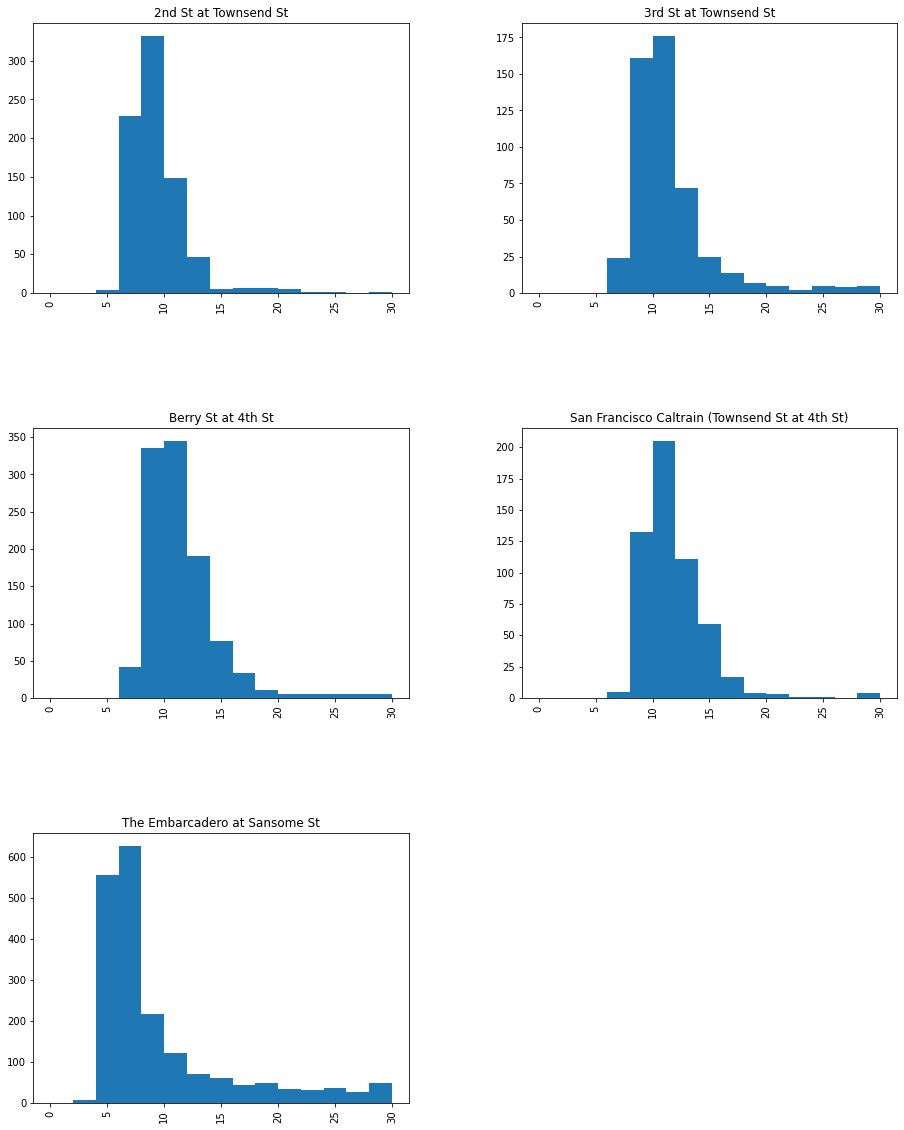

In [21]:
no_na_indexed=no_na[no_na.start_station_name.isin(popular_starts)].copy()
no_na_indexed['end_station']=no_na_indexed['end_station_name']
no_na_indexed=no_na_indexed.set_index('end_station_name')
##EXAMPLE - Journey times from San Francisco Ferry Building (Harry Bridges Plaza)
hist_1= no_na_indexed[no_na_indexed['start_station_name']=='San Francisco Ferry Building (Harry Bridges Plaza)'].merge(d_volumes['San Francisco Ferry Building (Harry Bridges Plaza)'][0], how='inner',left_index=True, right_index=True)
print('Time in minutes to named station from San Francisco Ferry Building (Harry Bridges Plaza)' )
hist_1[['end_station','trip_duration_min']][hist_1['trip_duration_min'] <=90].hist(by='end_station', bins=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],figsize=(15,20))



## We can now see a distribution of journey times in seconds between San Francisco Caltrain Station 2  (Townsend St at 4th St) and the five most common destinations from there
## This is information we can give the user to help them to plan their journey if starting from a particular station

Question 3b: Is the pricing system fair by gender? The cost is $3 for each journey under 30 minutes for non-subscribers

In [22]:
##aggregate for route and men and women
df_agg=no_na[['route','trip_duration_min','member_gender']].groupby(['route','member_gender']).agg({'trip_duration_min': [np.mean,np.size]})


df_agg.columns=df_agg.columns.droplevel(0)

df_agg.sort_values(['member_gender','size'],ascending=[True,False])[:10]

df_agg.reset_index(inplace=True)

##create dataframe with men and women data for easy visualisation
gender_diff=df_agg[df_agg['member_gender']=='Male'].merge(df_agg[df_agg['member_gender']=='Female'], left_on='route', right_on='route', suffixes=('_m', '_f'))

gd_plot=gender_diff[['route','mean_m', 'mean_f','size_m','size_f']].copy().sort_values(by='size_f',ascending=False)[:30]

gd_plot['Diff'] = gd_plot['mean_m'] - gd_plot['mean_f']
gd_plot.style.bar(subset=['Diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,route,mean_m,mean_f,size_m,size_f,Diff
19895,San Francisco Ferry Building (Harry Bridges Plaza) TO The Embarcadero at Sansome St,11.942857,14.266667,1295.000000,765.000000,-2.323810
6100,Berry St at 4th St TO San Francisco Ferry Building (Harry Bridges Plaza),10.161922,11.688854,1124.000000,646.000000,-1.526933
14942,Market St at 10th St TO Powell St BART Station (Market St at 4th St),7.220083,7.173729,727.000000,472.000000,0.046354
3968,4th St at 16th St TO San Francisco Ferry Building (Harry Bridges Plaza),14.201439,15.417910,278.000000,469.000000,-1.216472
1769,19th Street BART Station TO Grand Ave at Perkins St,7.252465,6.103004,1014.000000,466.000000,1.149461
21843,The Embarcadero at Sansome St TO San Francisco Ferry Building (Harry Bridges Plaza),9.834437,9.030501,604.000000,459.000000,0.803936
8715,Division St at Potrero Ave TO San Francisco Caltrain Station 2 (Townsend St at 4th St),4.897436,5.193548,858.000000,403.000000,-0.296112
21846,The Embarcadero at Sansome St TO Steuart St at Market St,6.334948,7.496164,1239.000000,391.000000,-1.161216
6242,Broadway at 30th St TO 19th Street BART Station,5.470255,5.469816,353.000000,381.000000,0.000439
18184,Powell St BART Station (Market St at 5th St) TO Market St at 10th St,8.057944,6.477778,535.000000,360.000000,1.580166


In [23]:
##Including only routes undertaken by male customers at least 100 times
gd_plot_2=gender_diff[['route','size_m', 'size_f']][gender_diff['size_m']>=100].copy() 
##We saw earlier that the male/ female ratio is about 3:1 so we need to reflect this in any route differences we may have
gd_plot_2['log_diff_from_normal'] = np.log((gd_plot_2['size_m']/gd_plot_2['size_f'])*(len(no_na[no_na['member_gender']=='Female'])/len(no_na[no_na['member_gender']=='Male'])))
#Find biggest differences
gd_plot_3=gd_plot_2.sort_values(by='log_diff_from_normal',ascending=True)
##Plot
gd_plot_3.style.bar(subset=['log_diff_from_normal'], align='mid', color=['#d65f5f', '#5fba7d'])

,route,size_m,size_f,log_diff_from_normal
21048,Steuart St at Market St TO 4th St at 16th St,123.000000,318.000000,-2.084984
18707,Rockridge BART Station TO Miles Ave at Cavour St,100.000000,203.000000,-1.843152
9139,El Embarcadero at Grand Ave TO El Embarcadero at Grand Ave,108.000000,187.000000,-1.684094
15888,Miles Ave at Cavour St TO Rockridge BART Station,113.000000,193.000000,-1.670419
19796,San Francisco Ferry Building (Harry Bridges Plaza) TO 4th St at 16th St,160.000000,273.000000,-1.669415
3968,4th St at 16th St TO San Francisco Ferry Building (Harry Bridges Plaza),278.000000,469.000000,-1.658098
6108,Berry St at 4th St TO The Embarcadero at Vallejo St,135.000000,209.000000,-1.572176
20701,Shattuck Ave at 55th St TO MacArthur BART Station,156.000000,238.000000,-1.557531
6153,Berry St at King St TO Berry St at 4th St,104.000000,154.000000,-1.527678
14728,MacArthur BART Station TO Shattuck Ave at 55th St,107.000000,143.000000,-1.425132


Recall from earlier that the ratio of trips by men to trips by women is about 3:1- we can see from this that for the most part, for the most popular routes where a significant number (here, defined as more than 100) trips by men are undertaken, there is not a significant difference in the overall male_female trip ratio- however there are some routes which have a reasonable number of trips which are far more favoured by men.

For example, the route Morrison Ave at Julian St TO Julian St at The Alameda has 398 trips by men with only 2 made by women- there may be a reasonable explanation for this, however this is an example of the capability of data analysis that we can do to enhance offering and help with safety. For example, can we see that there are two nearby stations to start/ end at and women are overwhelmingly choosing one over the other? 

We could use such data to help police with possible issues of public safety.